**Anti-Fraud Model** by *Sohail, Ahmed,* and *Hiten*

---

Using a **Feedforward Neural Network (FNN)** because our dataset is structured and tabular.

Our initial goal was that....

In [82]:
# IMPORTING NECESSARY LIBRARIES
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import KernelPCA

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf

import time
import seaborn as sns
import category_encoders as ce

In [83]:
# LOADING THE DATASET

import pandas as pd

df = pd.read_csv('Dataset\Cleaned_AntiFraud_Centre_Dataset.csv')

print(df.head())
print(f"\n\n{df.describe(include='all')}")
print("\n")

# Data type of each column
print(df.dtypes)

   Number ID Date Received Complaint Received Type        Country  \
0          1      1/2/2021            CAFC Website         Canada   
1          2      1/2/2021            CAFC Website         Canada   
2          3      1/2/2021            CAFC Website  Not Specified   
3          4      1/2/2021            CAFC Website  United States   
4          5      1/2/2021            CAFC Website         Canada   

     Province/State Fraud and Cybercrime Thematic Categories  \
0       Nova Scotia                                 Phishing   
1  British Columbia                           Identity Fraud   
2     Not Specified                                  Romance   
3        California                      Foreign Money Offer   
4           Ontario                              Merchandise   

  Solicitation Method         Gender Language of Correspondence  \
0        Text message         Female                    English   
1       Other/unknown         Female                    English   

------------------------------------ **Graphing and Analysis of Raw Data** --------------------------------

            Number ID Date Received Complaint Received Type Country  \
count   313976.000000        313976                  313976  313976   
unique            NaN          1458                      10     155   
top               NaN     3/18/2021            CAFC Website  Canada   
freq              NaN           624                  164920  238635   
mean    156988.500000           NaN                     NaN     NaN   
std      90637.208397           NaN                     NaN     NaN   
min          1.000000           NaN                     NaN     NaN   
25%      78494.750000           NaN                     NaN     NaN   
50%     156988.500000           NaN                     NaN     NaN   
75%     235482.250000           NaN                     NaN     NaN   
max     313976.000000           NaN                     NaN     NaN   

       Province/State Fraud and Cybercrime Thematic Categories  \
count          313976                                   313976   
unique         

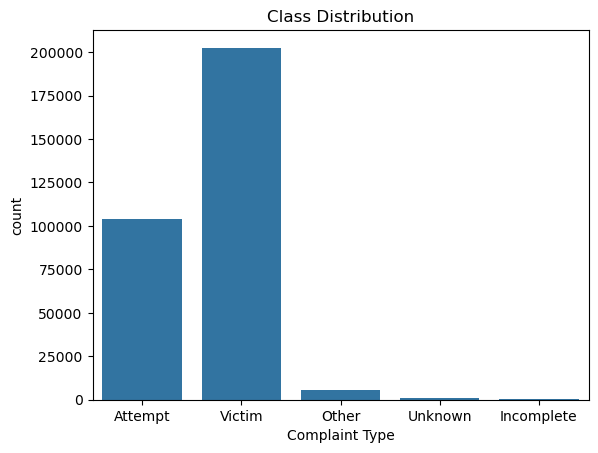

In [84]:
# GRAPH AND ANALYSIS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Dataset\Cleaned_AntiFraud_Centre_Dataset.csv')

# Statistical Summary of the dataset, some of the outputs are for numerical features only 
# so it will result in a value of NaN in the categorical features output
print(df.describe(include='all'))

# Our target is "Complaint Type". A victim = a fraud case and others are not fraud cases.
sns.countplot(x='Complaint Type', data=df)
plt.title('Class Distribution')
plt.show()

print("\n\n\n")


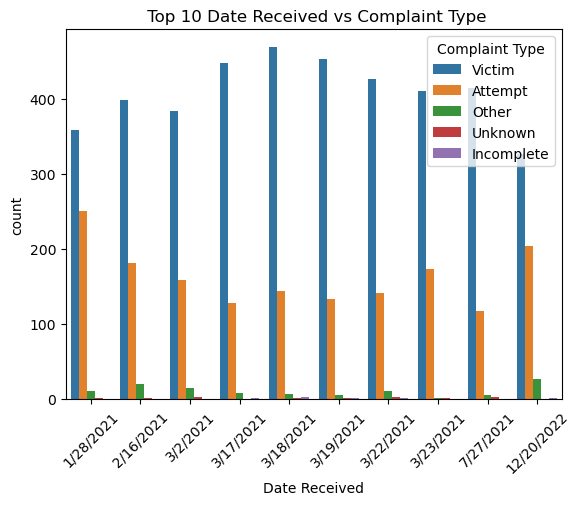

<Figure size 1600x600 with 0 Axes>

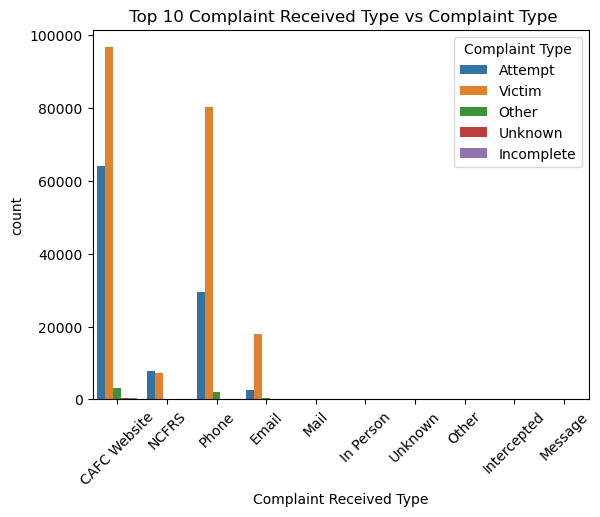

<Figure size 1600x600 with 0 Axes>

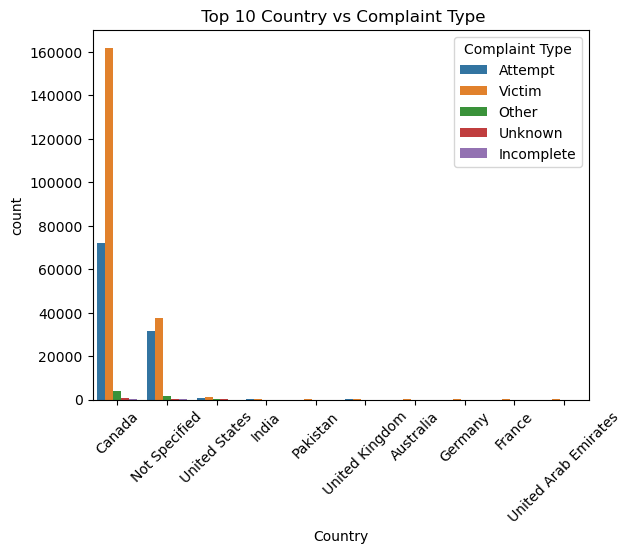

<Figure size 1600x600 with 0 Axes>

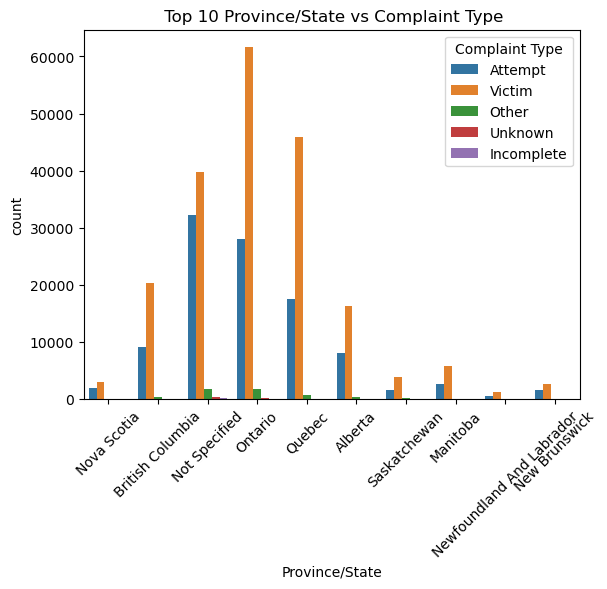

<Figure size 1600x600 with 0 Axes>

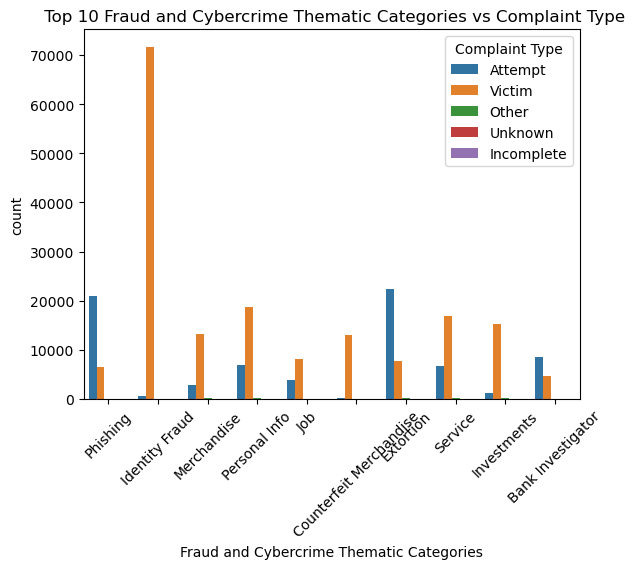

<Figure size 1600x600 with 0 Axes>

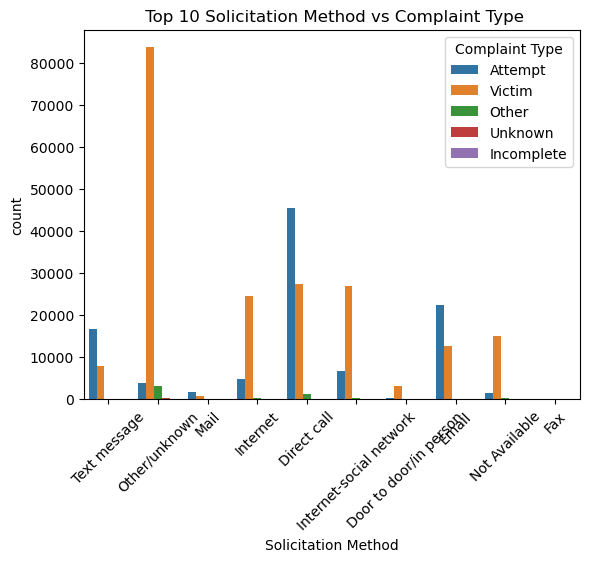

<Figure size 1600x600 with 0 Axes>

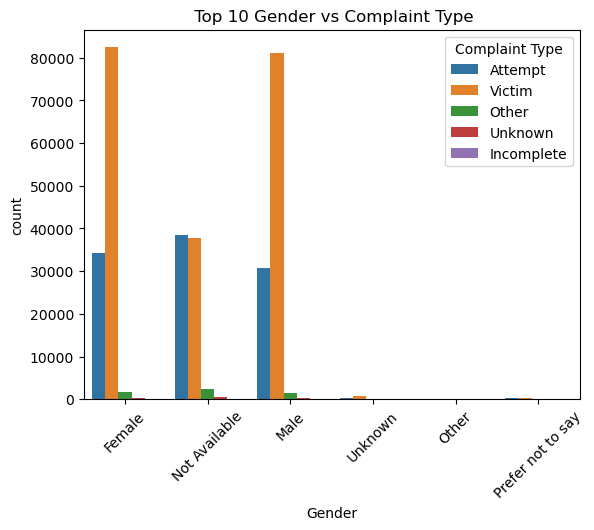

<Figure size 1600x600 with 0 Axes>

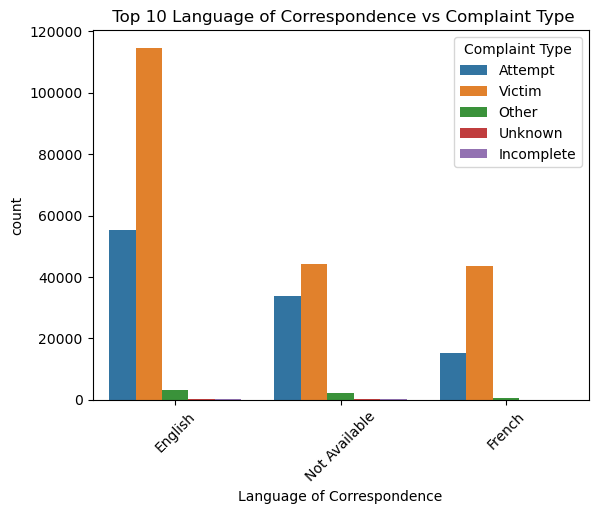

<Figure size 1600x600 with 0 Axes>

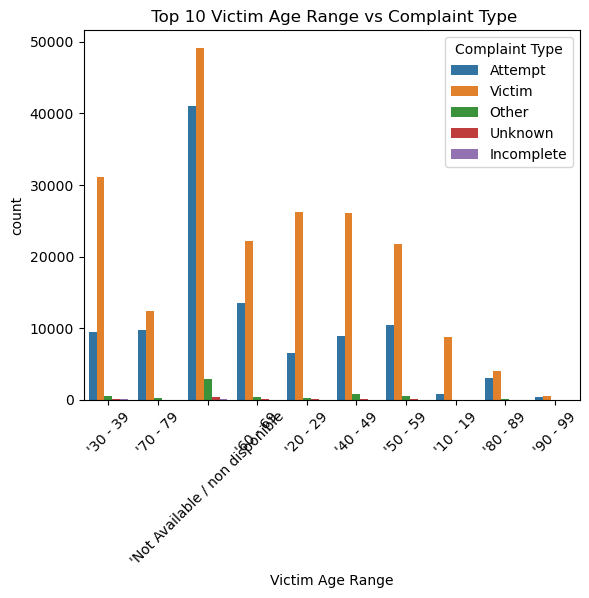

<Figure size 1600x600 with 0 Axes>

In [85]:
# FUNCTION TO SEE CORRELATION OF FEATURES - TARGET
# FUNCTION WILL PRINT 9 GRAPHS

import pandas as pd
df = pd.read_csv('Dataset\Cleaned_AntiFraud_Centre_Dataset.csv')
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_target_correlation(df, columns, target, top_n=10):
    for col in columns:
        
        top_categories = df[col].value_counts().nlargest(top_n).index
        filtered_df = df[df[col].isin(top_categories)]
        
        sns.countplot(x=col, hue=target, data=filtered_df)
        plt.title(f" Top {top_n} {col} vs {target}")
        plt.xticks(rotation=45)
        plt.figure(figsize=(16,6))
        plt.show()
        
        
columns = ['Date Received', 'Complaint Received Type', 'Country', 'Province/State', 'Fraud and Cybercrime Thematic Categories', 
           'Solicitation Method', 'Gender', 'Language of Correspondence', 'Victim Age Range']

target = 'Complaint Type'

plot_feature_target_correlation(df, columns, target)

In [86]:
# VIEWING TARGET VARIABLE STATISTICS

print(df["Complaint Type"].value_counts())

Complaint Type
Victim        202546
Attempt       104274
Other           5829
Unknown          888
Incomplete       439
Name: count, dtype: int64


----------------------------------------- **Pre-processing and Handling Missing Data** ------------------------------------------------

In [87]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.read_csv('Dataset\Cleaned_AntiFraud_Centre_Dataset.csv')

## [--HANDLING MISSING DATA--]---------------------------------------

# Convert Not Specified, Not Available, etc. into NaN value
df.replace(["Not Specified", "Not Available / non disponible", "Not Available"], pd.NA, inplace=True)

# Change NaN values of Province/State to Unknown
df['Province/State'] = df['Province/State'].fillna('Unknown')

# Change NaN Values of Country to Unknown
df['Country'] = df['Country'].fillna('Unknown')

# Change NaN Values of Solicitation Method to mode (most frequent value) to minimize
# missingness and reduce bias
mode_solicitation = df["Solicitation Method"].mode()[0]
df["Solicitation Method"] = df["Solicitation Method"].fillna(mode_solicitation)

# Change Gender NaN values to Unknown
df['Gender'] = df['Gender'].fillna('Unknown')

# Change Language of Correspondence NaN values to Unknown
df['Language of Correspondence'] = df['Language of Correspondence'].fillna('Unknown')

# Convert $x.xx to float number and replace missing values or 0 with a computed mean.
df["Dollar Loss"] = df["Dollar Loss"].replace('[\$,]', '', regex=True).astype(float)
df["Dollar Loss"] = df["Dollar Loss"].fillna(df["Dollar Loss"].mean())


## [--EXTRACTING DATE FEATURES--]-------------------------------------------------------

# Convert to DateTime format
df['Date Received'] = pd.to_datetime(df['Date Received'], errors='coerce')

# Create new features "Year", "Month", "Day", and "DayOfTheWeek"
df['Year'] = df['Date Received'].dt.year
df['Month'] = df['Date Received'].dt.month
df['Day'] = df['Date Received'].dt.day
df['DayOfTheWeek'] = df['Date Received'].dt.dayofweek


## [--VICTIM AGE RANGE TO ORDINAL VARIABLE--]---------------------------------------------------

age_order = {
    "'Not Available / non disponible": 0,
    "'Under 20": 1,
    "'20 - 29": 2,
    "'30 - 39": 3,
    "'40 - 49": 4,
    "'50 - 59": 5,
    "'60 - 69": 6,
    "'70 - 79": 7,
    "'80 and over": 8
}

df["Victim Age Range"] = df["Victim Age Range"].map(age_order)

## [--TARGET VAIRABLE --> BINARY--]---------------------------------------------------------------

df['Is_Fraud'] = df['Complaint Type'].apply(lambda x: 1 if x.strip() == 'Victim' else 0)

## [--DROPPING UNNECESSARY COLUMNS--]-------------------------
cols_to_drop = [
    "Number ID",        # Just an identifier no real impact
    "Complaint Type",   # Redundant because we are changed it to binary
    "Date Received",    # Already split into year, day, month, and day of the week
]

df = df.drop(columns = cols_to_drop, axis=1)

## [--SCALING NUMERICAL VARIABLES--]--------------------------------------------------------------------

# Fixing cyclic variables to reflect actual cycles (months, days of the week)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['DayOfTheWeek_sin'] = np.sin(2 * np.pi * df['DayOfTheWeek'] / 7)
df['DayOfTheWeek_cos'] = np.cos(2 * np.pi * df['DayOfTheWeek'] / 7)

scaler = StandardScaler()

numerical_features = ['Victim Age Range', 'Number of Victims', 'Dollar Loss', 'Year', 'Month_sin', 'Month_cos', 'DayOfTheWeek_sin', 'DayOfTheWeek_cos' ]

df[numerical_features] = scaler.fit_transform(df[numerical_features])

-------------------------------------------------------- **Splitting Into Training and Testing Split** -------------------------------------------------

In [88]:
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from category_encoders import TargetEncoder 
from sklearn.preprocessing import LabelEncoder, StandardScaler

## [--DEFINING THE TESTING/TRAINING SPLIT--]-------------------------------------------------

x = df.drop(columns=["Is_Fraud"])
y = df["Is_Fraud"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

## [--TARGET ENCODING "COUNTRY" (HIGH CARDINALITY)--]----------------------------------------

encoder = TargetEncoder()
x_train["Country"] = encoder.fit_transform(x_train["Country"], y_train)

x_test["Country"] = encoder.transform(x_test["Country"])

## [--LABEL ENCODING CATEGORICAL VARIABLES]--------------------------------------------------

label_encoder = LabelEncoder()

combined_data = pd.concat([x_train["Province/State"], x_test["Province/State"]], axis=0)
label_encoder.fit(combined_data)
x_train["Province/State"] = label_encoder.transform(x_train["Province/State"])
x_test["Province/State"] = label_encoder.transform(x_test["Province/State"])

# -----

combined_data = pd.concat([x_train["Complaint Received Type"], x_test["Complaint Received Type"]], axis=0)
label_encoder.fit(combined_data)
x_train["Complaint Received Type"] = label_encoder.transform(x_train["Complaint Received Type"])
x_test["Complaint Received Type"] = label_encoder.transform(x_test["Complaint Received Type"])

#-----

combined_data = pd.concat([x_train["Gender"], x_test["Gender"]], axis=0)
label_encoder.fit(combined_data)
x_train["Gender"] = label_encoder.transform(x_train["Gender"])
x_test["Gender"] = label_encoder.transform(x_test["Gender"])

#------

combined_data = pd.concat([x_train["Fraud and Cybercrime Thematic Categories"], x_test["Fraud and Cybercrime Thematic Categories"]], axis=0)
label_encoder.fit(combined_data)
x_train["Fraud and Cybercrime Thematic Categories"] = label_encoder.transform(x_train["Fraud and Cybercrime Thematic Categories"])
x_test["Fraud and Cybercrime Thematic Categories"] = label_encoder.transform(x_test["Fraud and Cybercrime Thematic Categories"])

#------

combined_data = pd.concat([x_train["Solicitation Method"], x_test["Solicitation Method"]], axis=0)
label_encoder.fit(combined_data)
x_train["Solicitation Method"] = label_encoder.transform(x_train["Solicitation Method"])
x_test["Solicitation Method"] = label_encoder.transform(x_test["Solicitation Method"])

#------

combined_data = pd.concat([x_train["Language of Correspondence"], x_test["Language of Correspondence"]], axis=0)
label_encoder.fit(combined_data)
x_train["Language of Correspondence"] = label_encoder.transform(x_train["Language of Correspondence"])
x_test["Language of Correspondence"] = label_encoder.transform(x_test["Language of Correspondence"])



-------------------------------------------------------- **Building a Deep Learning FNN Model** --------------------------------------------------------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import KernelPCA

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC, roc_curve
import tensorflow as tf

import time
import seaborn as sns
import category_encoders as ce

## DEFINE INPUT LAYERS

province_input = Input(shape=(1,), name="Province/State")
country_input = Input(shape=(1,), name="Country")    
dollar_loss_input = Input(shape=(1,), name="Dollar Loss")
victim_age_range_input = Input(shape=(1,), name="Victim Age Range")
complaint_received_type_input = Input(shape=(1,), name="Complaint Received Type")
fraud_and_cybercrime_category_input = Input(shape=(1,), name="Fraud and Cybercrime Thematic Categories")
solicitation_input = Input(shape=(1,), name="Solicitation Method")
gender_input = Input(shape=(1,), name="Gender")
number_of_victims_input = Input(shape=(1,), name="Number of Victims")
year_input = Input(shape=(1,), name="Year")
month_sin_input = Input(shape=(1,), name="Month_sin")
month_cos_input = Input(shape=(1,), name="Month_cos")
dayoftheweek_sin_input = Input(shape=(1,), name="DayOfTheWeek_sin")
dayoftheweek_cos_input = Input(shape=(1,), name="DayOfTheWeek_cos")
day_input = Input(shape=(1,), name="Day")

# CONECTATE ALL INPUTS
all_inputs = Concatenate()([
    province_input,
    country_input,
    dollar_loss_input,
    victim_age_range_input,
    complaint_received_type_input,
    fraud_and_cybercrime_category_input,
    solicitation_input,
    gender_input,
    number_of_victims_input,
    year_input,
    month_sin_input,
    month_cos_input,
    dayoftheweek_sin_input,
    dayoftheweek_cos_input,
    day_input
])

# DEFINE HIDDEN LAYERS
x = Dense(128, activation='relu')(all_inputs)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

# OUTPUT LAYER
output = Dense(1, activation='sigmoid')(x)


# BUILD THE MODEL
model = Model(inputs=[
    province_input, country_input, dollar_loss_input, victim_age_range_input,
    complaint_received_type_input, fraud_and_cybercrime_category_input,
    solicitation_input, gender_input, number_of_victims_input,
    year_input, month_sin_input, month_cos_input, dayoftheweek_sin_input,
    dayoftheweek_cos_input, day_input
], outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC(), 'binary_crossentropy']
)

model.summary()



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Province/State (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 Country (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Dollar Loss (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Victim Age Range (InputLayer)  [(None, 1)]          0           []                               
                                                                                            

------------------------------------------------------ **Training the Model** ------------------------------------------------------------------

Epoch 1/10
7850/7850 [==============================] - 63s 8ms/step - loss: 0.6512 - accuracy: 0.6450 - precision_6: 0.6451 - recall_6: 0.9999 - auc_6: 0.5013 - binary_crossentropy: 0.6512 - val_loss: 0.6505 - val_accuracy: 0.6451 - val_precision_6: 0.6451 - val_recall_6: 1.0000 - val_auc_6: 0.5000 - val_binary_crossentropy: 0.6505
Epoch 2/10
7850/7850 [==============================] - 61s 8ms/step - loss: 0.6506 - accuracy: 0.6451 - precision_6: 0.6451 - recall_6: 1.0000 - auc_6: 0.5010 - binary_crossentropy: 0.6506 - val_loss: 0.6504 - val_accuracy: 0.6451 - val_precision_6: 0.6451 - val_recall_6: 1.0000 - val_auc_6: 0.5000 - val_binary_crossentropy: 0.6504
Epoch 3/10
7850/7850 [==============================] - 65s 8ms/step - loss: 0.6505 - accuracy: 0.6451 - precision_6: 0.6451 - recall_6: 1.0000 - auc_6: 0.4982 - binary_crossentropy: 0.6505 - val_loss: 0.6504 - val_accuracy: 0.6451 - val_precision_6: 0.6451 - val_recall_6: 1.0000 - val_auc_6: 0.5000 - val_binary_crossentropy: 0.

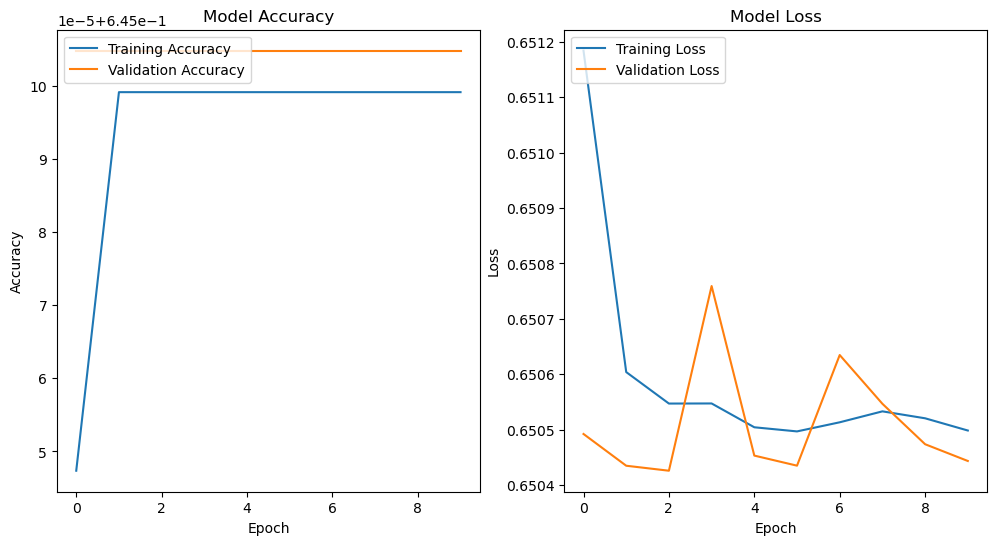

1963/1963 [==============================] - 11s 6ms/step - loss: 0.6504 - accuracy: 0.6451 - precision_6: 0.6451 - recall_6: 1.0000 - auc_6: 0.5000 - binary_crossentropy: 0.6504
Test Accuracy: 0.6451
Test Precision: 0.6451
Test Recall: 1.0000
Test AUC: 0.5000
Test Binary Crossentropy: 0.6504


Total Evaluation Time: 0.0010 seconds

1963/1963 [==============================] - 9s 4ms/step
Accuracy: 0.6451047837441876
Precision: 0.6451047837441876
Recall: 1.0


In [90]:
x_train = {
    'Province/State': x_train["Province/State"].values,
    'Country': x_train["Country"].values,
    'Dollar Loss': x_train["Dollar Loss"].values,
    'Victim Age Range': x_train["Victim Age Range"].values,
    'Complaint Received Type': x_train["Complaint Received Type"].values,
    'Fraud and Cybercrime Thematic Categories': x_train["Fraud and Cybercrime Thematic Categories"].values,
    'Solicitation Method': x_train["Solicitation Method"].values,
    'Gender': x_train["Gender"].values,
    'Number of Victims': x_train["Number of Victims"].values,
    'Year': x_train["Year"].values,
    'Month_sin': x_train["Month_sin"].values,
    'Month_cos': x_train["Month_cos"].values,
    'DayOfTheWeek_sin': x_train["DayOfTheWeek_sin"].values,
    'DayOfTheWeek_cos': x_train["DayOfTheWeek_cos"].values,
    'Day': x_train["Day"].values
}

x_test = {
    'Province/State': x_test["Province/State"].values,
    'Country': x_test["Country"].values,
    'Dollar Loss': x_test["Dollar Loss"].values,
    'Victim Age Range': x_test["Victim Age Range"].values,
    'Complaint Received Type': x_test["Complaint Received Type"].values,
    'Fraud and Cybercrime Thematic Categories': x_test["Fraud and Cybercrime Thematic Categories"].values,
    'Solicitation Method': x_test["Solicitation Method"].values,
    'Gender': x_test["Gender"].values,
    'Number of Victims': x_test["Number of Victims"].values,
    'Year': x_test["Year"].values,
    'Month_sin': x_test["Month_sin"].values,
    'Month_cos': x_test["Month_cos"].values,
    'DayOfTheWeek_sin': x_test["DayOfTheWeek_sin"].values,
    'DayOfTheWeek_cos': x_test["DayOfTheWeek_cos"].values,
    'Day': x_test["Day"].values
}


start_time = time.time()

# TRAIN MODEL
history = model.fit(
    x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=1
)

end_time = time.time()

training_time = end_time - start_time
print(f"\nTraining Time: {training_time:.2f} seconds\n")

# TRAINING HISTORY
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

# EVALUATE MODEL

test_loss, test_accuracy, test_precision, test_recall, test_auc, test_bce = model.evaluate(x_test, y_test, verbose=1)

start_time = time.time()
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Binary Crossentropy: {test_bce:.4f}\n")
end_time = time.time()

print(f"\nTotal Evaluation Time: {(end_time - start_time):.4f} seconds\n")

# TESTING/PREDICTING

y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_binary)
print(f"AUC: {auc}")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")